In [1]:
import os
os.environ["HF_DIFFUSERS_CACHE"] = "/root/autodl-tmp"
os.environ["no_proxy"] = "localhost,127.0.0.1,modelscope.com,aliyuncs.com,tencentyun.com,wisemodel.cn"
os.environ["http_proxy"] = "http://172.20.0.113:12798"
os.environ["https_proxy"] = "http://172.20.0.113:12798"
os.environ["REQUESTS_CA_BUNDLE"] = "/etc/ssl/certs/ca-certificates.crt"
os.environ["SSL_CERT_FILE"] = "/etc/ssl/certs/ca-certificates.crt"

In [2]:
%matplotlib widget
import argparse
import gc
import random
import torch
from PIL import Image
from torchvision.transforms import PILToTensor
from src.models.dift_sd import SDFeaturizer
from src.utils.visualization import Demo

In [3]:
torch.cuda.set_device(0)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:18<00:00,  2.76it/s]


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([2, 1280, 64, 64])
(1024, 1024) (1024, 1024)


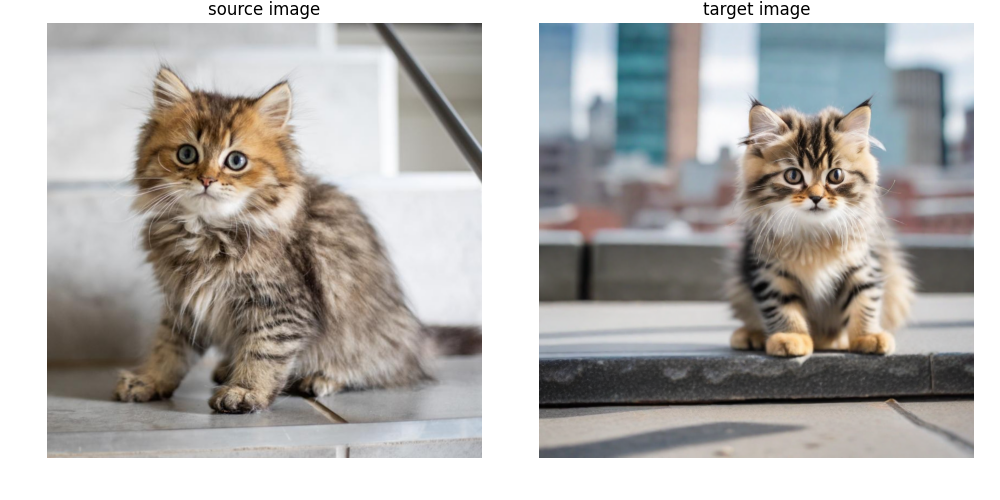

: 

In [ ]:
import cv2
import torch
import numpy as np
from dift_pipeline_sdxl_ipadapter import StableDiffusionXLPipeline
from PIL import Image
from dift_unet_sdxl_ip_adapter import Dift_UNet2DConditionModel
from ip_adapter.ip_adapter import IPAdapterXL, IPAdapterPlusXL
from transformers import CLIPTextModel, CLIPTokenizer, CLIPVisionModelWithProjection, CLIPTextModelWithProjection
# New added
from accelerate import Accelerator
import json
import argparse
import inversion_pipeline_sdxl
from diffusers.utils import load_image
from diffusers import DDIMScheduler
from utils.general_utils import gaussian_smooth
import torch.nn.functional as F

def collate_fn(data):
    # New added
    comb_idxes = [example["comb_idx"] for example in data]
    prompts = [example["prompt"] for example in data]
    prompt_token_lens = [example["prompt_token_len"] for example in data]
    entity_names = [example["entity_names"] for example in data]
    clip_images, entity_indexes = [], []
    for example in data:
        clip_images.extend([example["entity_imgs"][0], example["entity_imgs"][1]])
        entity_indexes.append(example["entity_indexes"])

    return {
        "comb_idxes": comb_idxes,
        "clip_images": clip_images,
        "prompts": prompts,
        "prompt_token_lens": prompt_token_lens,
        "entity_names": entity_names,
        "entity_indexes": entity_indexes,
    }


def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


def recover_image(img_tensor, mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711)):
    mean = torch.FloatTensor(mean).cuda() if img_tensor.device.type == 'cuda' else torch.FloatTensor(mean)
    std = torch.FloatTensor(std).cuda() if img_tensor.device.type == 'cuda' else torch.FloatTensor(std)
    mean = mean.view(-1, 1, 1)
    std = std.view(-1, 1, 1)
    img_tensor = img_tensor * std + mean
    img_tensor = torch.clamp(img_tensor, 0, 1)
    img_np = img_tensor.permute(1, 2, 0).mul(255).cpu().byte().numpy()
    img_pil = Image.fromarray(img_np, 'RGB')

    return img_pil


def get_token_len(entity_name, tokenizer):
    entity_tokens = tokenizer(entity_name, return_tensors="pt").input_ids[0][1:-1]
    return len(entity_tokens)


def str2bool(v):
    if isinstance(v, bool):
        return v
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')

def parse_args():
    class Args:
        base_model_path = "stable-diffusion-xl-base-1.0/"
        image_encoder_path = "IP-Adapter/sdxl_models/image_encoder/"
        ip_ckpt = "IP-Adapter/sdxl_models/ip-adapter_sdxl.bin"
        output_dir = "output/vis_sdxl/"
        scale = 0.75
        reference_image1_path = "assets/combination_1/cat.jpg"
        num_samples = 1
        is_plus = False

    return Args()

args = parse_args()
base_model_path = args.base_model_path
image_encoder_path = args.image_encoder_path
ip_ckpt = args.ip_ckpt

accelerator = Accelerator()
device = "cuda"
resolution = 1024
num_inference_step = 50
prompt = "a cat is eating with the background of boston city"


category = "cat"
# category = "car"

num_samples = args.num_samples
scale = args.scale
output_dir = args.output_dir

# Load model
tokenizer = CLIPTokenizer.from_pretrained(base_model_path, subfolder="tokenizer")
tokenizer_2 = CLIPTokenizer.from_pretrained(base_model_path, subfolder="tokenizer_2")

unet = Dift_UNet2DConditionModel.from_pretrained(base_model_path, subfolder="unet", torch_dtype=torch.float16)

# Load SDXL pipeline
pipe = StableDiffusionXLPipeline.from_pretrained(
    base_model_path,
    unet=unet,
    torch_dtype=torch.float16,
    add_watermarker=False,
)
pipe.enable_vae_slicing()
pipe.to(device)

pipe.scheduler = DDIMScheduler(
    beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear",
    clip_sample=False, set_alpha_to_one=False)

image = np.array(load_image(args.reference_image1_path).resize((1024, 1024)))
ref_latents = inversion_pipeline_sdxl.ddim_inversion(pipe, image, f"a {category}", num_inference_step, 7.5)
ref_dift = pipe.unet.dift_latent_store.dift_features["260_0"]
_, ref_dift = ref_dift.chunk(2)
cur_model = IPAdapterPlusXL if args.is_plus else IPAdapterXL
if ip_ckpt is None:
    ip_model = cur_model(pipe, image_encoder_path, ip_ckpt=None, device=device)
else:
    ip_model = cur_model(pipe, image_encoder_path, ip_ckpt=ip_ckpt, device=device)
os.makedirs(output_dir, exist_ok=True)

image = Image.open(args.reference_image1_path)

generated_images, dift_feature = ip_model.generate(pil_image=image, num_samples=num_samples, num_inference_steps=num_inference_step, prompt=prompt, scale=scale)
_, dift_feature = dift_feature["260_0"].chunk(2)
from src.utils.visualization import Demo
from PIL import Image

# 1. 重新加载 ref image（如果你手头已经有 PIL.Image 对象，也可以跳过这步）
ref_img = Image.open(args.reference_image1_path).convert("RGB")
ref_img = ref_img.resize((1024, 1024))
# 2. 拿第一张生成图来做示例匹配
gen_img = generated_images[0]

# 3. Dift 特征通常是形状 [1, C, H, W] 的张量，这里去掉 batch 维并放到 CPU 上
# ref_feat = ref_dift.squeeze(0).cpu()
# gen_feat = dift_feature.squeeze(0).cpu()
ft = torch.cat([ref_dift, dift_feature], dim=0)
# 4. Demo 接受一个图片列表和一个对应的特征列表，以及原始图片尺寸（假设正方形）

raw_feats = torch.cat([ref_dift, dift_feature], dim=0)
images = [ref_img, gen_img]
print(raw_feats.shape)
batch_size = 2
do_smooth = True 

if raw_feats.shape[0] == 2 * batch_size:
    raw_feats = raw_feats[batch_size:]

if do_smooth:
    feats = torch.stack(
        [gaussian_smooth(f, kernel_size=3, sigma=1) for f in raw_feats],
        dim=0
    )
else:
    feats = raw_feats


ft = feats
orig_size = images[0].size[0]
print(images[0].size,images[1].size)
demo = Demo([ref_img, gen_img], ft, orig_size)
demo.plot_img_pairs(fig_size=5)